In [282]:
## for scraping

import requests
import numpy as np
import pandas as pd
import re
from sklearn.svm import SVC
from bs4 import BeautifulSoup
from sklearn.neighbors import KNeighborsClassifier 
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
##skill learn 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy 
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.base import TransformerMixin
from sklearn.metrics import cohen_kappa_score
from sklearn.decomposition import PCA
import nltk
from nltk.collocations import *
nltk.download('genesis')


[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Package genesis is already up-to-date!


True

In [194]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [195]:

def getting_text(URLS):
    datas=[]
    titels=[]
    for URL in URLS:
        data=''
        page = requests.get(URL)
        results = BeautifulSoup(page.content, 'html.parser')
        job_elems = results.find_all('div', attrs={'class':'chapter'})
        titel = results.find_all('h1')
        for job_elem in job_elems:
            if None in (job_elem):
                continue
            data+=job_elem.text.strip()
        datas.append(data)
        titels.append(titel)
    return datas,titels


In [196]:
def cleaning_text(datas):
    reviews=[]
    import nltk
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    from nltk.stem.porter import PorterStemmer
    for data in datas:
        review = re.sub('[^a-zA-Z0-9]', ' ', str(data))
        review=re.sub('<[^<]+?>', '', str(review))
        review = review.lower()
        review = review.split()
        ps = PorterStemmer()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review=" ".join(review)
        review=review.split()
        reviews.append(review)
    return reviews

In [197]:
def cleaning_titletext(datas):
    reviews=[]
    for data in datas:
        review = re.sub('[^a-zA-Z0-9]', ' ', str(data))
        review = re.sub('  ', ' ', str(data))
        review=re.sub('<[^<]+?>', '', str(data))
        review=review.strip()
        review = review.lower()
        review=" ".join(review.split())
        review=review.split()
        reviews.append(review)
    z=[]
    for x in reviews:
        z.append(" ".join(x))
    return z

In [198]:
def get_randomsample(reviews,title1):
        mo = pd.DataFrame()
        xie = pd.DataFrame()
        
        
        for x in range(len(title1)):
            m=[]
            for i in range(200):

                datai=np.random.choice(range(len(reviews[x])-150))
                dataf=reviews[x][datai:datai+150]
                m.append(" ".join(dataf))
            xie["Text"] =m 
            xie["label"]=title1[x]
            mo=mo.append(xie, ignore_index=True)
        
        return mo

        

In [199]:
def wordCloudPlot(name):
  wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
  wc = wc.generate(str(mo.loc[mo['label'] == name, 'Text']))
  fig = plt.figure(num=1)
  plt.axis('off')
  plt.title('Top words for '+name, 
            fontdict={'size': 22,  'verticalalignment': 'bottom'})
  plt.imshow(wc, cmap=None)
  plt.show()

In [200]:
def tnesplot(pip,X,y,lable):
  tsne = TSNE(n_components=2, verbose=1, random_state=123)
  NEWX=pip["preprocessor"].transform(X)
  z = tsne.fit_transform(NEWX)
  df = pd.DataFrame()
  df["y"] = y
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  Title=" T-SNE projection "+lable

  sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                  palette=sns.color_palette("hls", 5),
                  data=df).set(title=Title)


In [201]:
def BOW(df):
    all_Partitions = list(df["Text"])
    
    vectorizer = CountVectorizer(analyzer = "word")
    bow_matrix = vectorizer.fit(all_Partitions)
    feature_names = vectorizer.vocabulary_
    
    bow_matrix = vectorizer.transform(all_Partitions)
    feature_array = bow_matrix.toarray()
    
    display(pd.DataFrame(feature_array, columns=feature_names))
    return feature_array



In [202]:
def eva(pipe1,X,y,name):
  if name== 'kmeans':
    preprocessed_data = pipe1["preprocessor"].transform(X)

    predicted_labels = pipe1["clusterer"][name].labels_
  else:
    predicted_labels=pipe1.fit_predict(X)
    preprocessed_data = pipe1["preprocessor"].transform(X)
  Finall= newY(predicted_labels,X,y)


  print('the silhouette score is : {:.2f}'.format(silhouette_score(preprocessed_data, predicted_labels)))
  print('the v_measure score is : {:.2f}'.format(v_measure_score(predicted_labels,y)))
  print('the cohen kappa score is : {:.2f}'.format(cohen_kappa_score( Finall['yhat'],Finall['newy'])))
  return Finall,predicted_labels



In [231]:
def plot_elbow(pipe):
  wcss = []
  pipe.fit(X)
  NEWX=pipe["preprocessor"].transform(X)
  for i in range(1, 11):
      pipe["clusterer"]["kmeans"].n_clusters= i
      pipe.fit(X)

      wcss.append(pipe["clusterer"]["kmeans"].inertia_)
  pipe["clusterer"]["kmeans"].n_clusters=5
  pipe.fit(X)
  plt.plot(range(1, 11), wcss)
  plt.title('Elbow Method')
  plt.xlabel('Number of clusters')
  plt.ylabel('WCSS')
  plt.show()
  

In [204]:
def newY(yhat,X,y):
  data = pd.DataFrame()
  newdata = pd.DataFrame()
  data['yhat']=yhat
  data['X']=X
  data['y']=y
  
  for i in range(5):
    c1=data[data['y']==i]
    c1['newy']=int(c1['yhat'].mode())
    
    newdata=newdata.append(c1)
 
 
  return newdata

In [205]:
def wrongdata(map):
  newmap=map[map['newy']!=map['yhat']]
  return newmap

# Getting the books

In [206]:
data,title=getting_text(['https://www.gutenberg.org/files/10/10-h/10-h.htm',
                         'https://www.gutenberg.org/files/158/158-h/158-h.htm',
                        'https://www.gutenberg.org/files/1524/1524-h/1524-h.htm',
                         'https://www.gutenberg.org/files/36/36-h/36-h.htm',
                         'https://www.gutenberg.org/files/20/20-h/20-h.htm'
                        ])
review=cleaning_text(data)
title1=cleaning_titletext(title)
mo=get_randomsample(review,title1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [207]:
mo

,Text,label
0,cometh nation shall make land desol none shall...,[the king james version of the bible]
1,jew name apollo born alexandria eloqu man migh...,[the king james version of the bible]
2,mani isl thu saith lord god tyru thou hast sai...,[the king james version of the bible]
3,lord jealousi shall smoke man curs written boo...,[the king james version of the bible]
4,shall pass shall come unto us made lie refug f...,[the king james version of the bible]
...,...,...
995,sacr influenc light appear wall heav n shoot f...,[ paradise lost]
996,heav nli spirit bright littl inferior thought ...,[ paradise lost]
997,doom frail man strictli much piti enclin appea...,[ paradise lost]
998,us work mind chang vehement desir delicaci mea...,[ paradise lost]


In [208]:
mo.groupby('label').label.count()

label
[ paradise lost]                              200
[emma]                                        200
[the king james version of the bible]         200
[the tragedy of hamlet, prince of denmark]    200
[the war of the worlds]                       200
Name: label, dtype: int64

# Visualization:

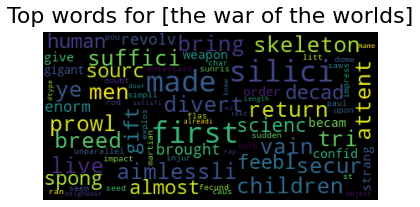

In [209]:
wordCloudPlot('[the war of the worlds]')

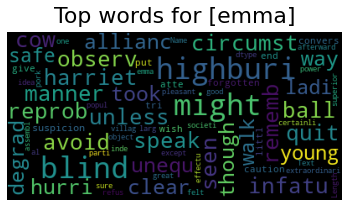

In [210]:
wordCloudPlot('[emma]')

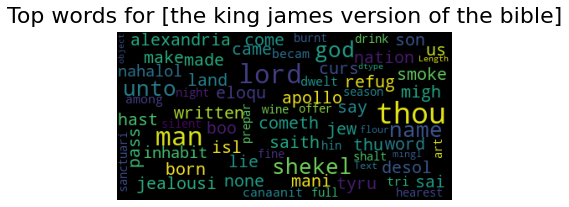

In [211]:
wordCloudPlot('[the king james version of the bible]')

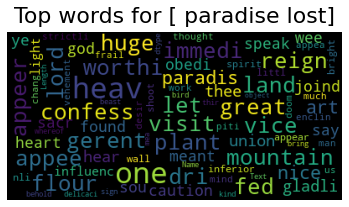

In [212]:
wordCloudPlot('[ paradise lost]')

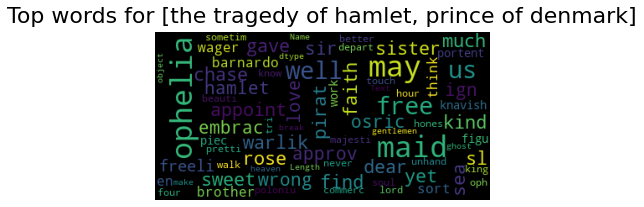

In [213]:
wordCloudPlot('[the tragedy of hamlet, prince of denmark]')


# data prepare with KMeans and HC example and EVA with silhouette_score and Kapaa 

In [214]:
X = mo['Text']
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
y = LE.fit_transform(mo['label'])



# Pipline making 

bow

To dense problem solver 

In [215]:
  to_dense = Pipeline([('to_dense', DenseTransformer()), ])

PC

In [216]:
Pca=Pipeline([ ("pca", PCA(n_components=650))])

In [217]:
preprocessor = Pipeline(
    [('bow', CountVectorizer()),
     ('to_dense', to_dense),
    ]
)

LDA

In [218]:
preprocessor1 = Pipeline(
    [('bow', CountVectorizer()),
     ('lda',LatentDirichletAllocation())

     ]
)


TF-IDF

In [219]:

preprocessor2 = Pipeline(
    [('bow', CountVectorizer()),
     ('tfid', TfidfTransformer()),
     ('to_dense', to_dense),

     ]
)


PCA BOW

In [220]:
preprocessor3 = Pipeline(
    [('bow', CountVectorizer()),
     ('to_dense', to_dense),
     ('Pca', Pca),

    ]
)

In [221]:
preprocessor4 = Pipeline(
    [('bow', CountVectorizer()),
     ('tfid', TfidfTransformer()),
     ('to_dense', to_dense),

     ('Pca', Pca),

    ]
)

In [222]:
preprocessor5 = Pipeline(
    [('bow', CountVectorizer()),
    ('lda',LatentDirichletAllocation(n_components=5))


    ]
)

Kmeans

In [223]:
Kmeanclusterer = Pipeline(
   [
       ("kmeans",
           KMeans(
               n_clusters=5,
               init="k-means++",
               random_state=42,
           ),
       ),
   ]
)

HC

In [224]:
HC = Pipeline(
   [
       (
            "HC",AgglomerativeClustering(n_clusters = 5)
           ,
       ),
   ]
)

EM

In [225]:
from sklearn.mixture import GaussianMixture
EM = Pipeline(
   [
       (
           "EM",GaussianMixture(n_components=5)
           ,
       ),
   ]
)



# pipeline combination 

Kmean

In [226]:
KMpipline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", Kmeanclusterer)
    ]
)

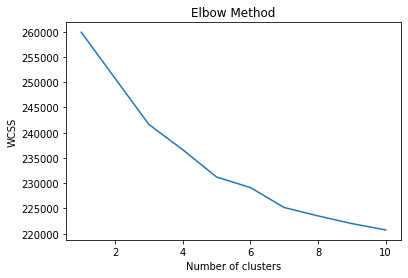

In [232]:
plot_elbow(KMpipline)

In [233]:
map,yhat=eva(KMpipline,X,y,'kmeans')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


the silhouette score is : 0.02
the v_measure score is : 0.84
the cohen kappa score is : 0.89


[t-SNE] Computing 91 nearest neighbors...

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,



[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.788s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


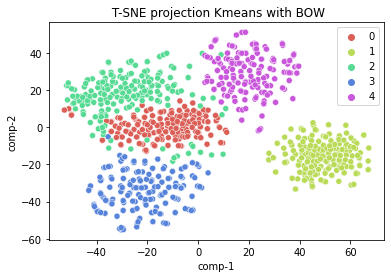

In [234]:
tnesplot(KMpipline,map['X'],map['y'],"Kmeans True Y with BOW")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.737s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


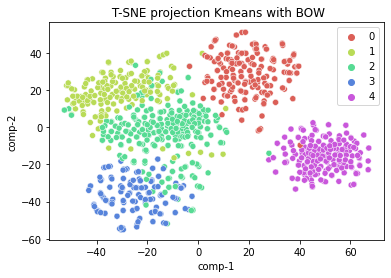

In [235]:
tnesplot(KMpipline,map['X'],map['yhat'],"Kmeans with BOW")

In [236]:
KMpipline1 = Pipeline(
    [
        ("preprocessor", preprocessor1),
        ("clusterer", Kmeanclusterer)
    ]
)

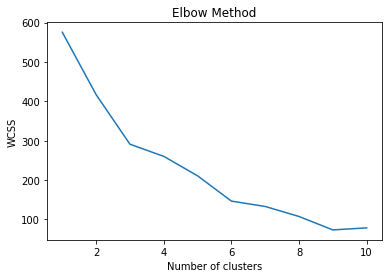

In [237]:
plot_elbow(KMpipline1)

In [238]:
map,yhat=eva(KMpipline1,X,y,'kmeans')

the silhouette score is : 0.37
the v_measure score is : 0.74
the cohen kappa score is : 0.84


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.753s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


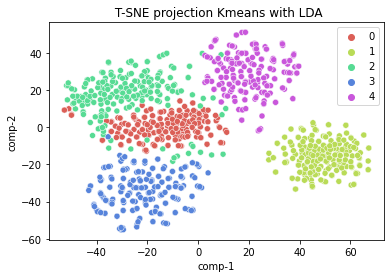

In [239]:
tnesplot(KMpipline,map['X'],map['y'],"Kmeans True Y with LDA")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.750s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


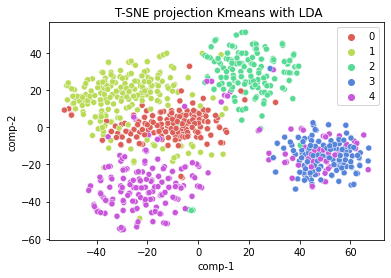

In [240]:
tnesplot(KMpipline,map['X'],map['yhat'],"Kmeans with LDA")

In [241]:
KMpipline2 = Pipeline(
    [
        ("preprocessor", preprocessor2),
        ("clusterer", Kmeanclusterer)
    ]
)

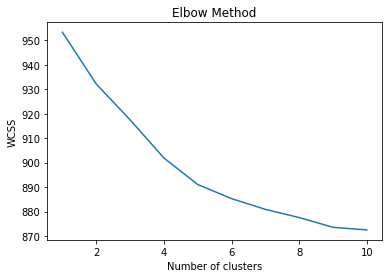

In [242]:
plot_elbow(KMpipline2)

In [243]:
map,yhat=eva(KMpipline2,X,y,'kmeans')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


the silhouette score is : 0.03
the v_measure score is : 0.95
the cohen kappa score is : 0.98


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.738s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


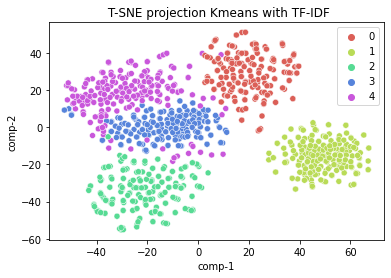

In [244]:
tnesplot(KMpipline,map['X'],map['newy'],"Kmeans True Y with TF-IDF")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.010s...
[t-SNE] Computed neighbors for 1000 samples in 0.759s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


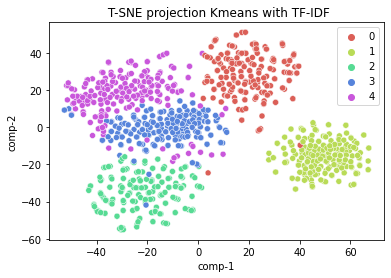

In [245]:
tnesplot(KMpipline,map['X'],map['yhat'],"Kmeans with TF-IDF")

HC

In [246]:
HCpipline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", HC)
    ]
)

In [247]:
map,yhat=eva(HCpipline,X,y,'HC')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


the silhouette score is : 0.02
the v_measure score is : 0.95
the cohen kappa score is : 0.98


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.010s...
[t-SNE] Computed neighbors for 1000 samples in 0.741s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


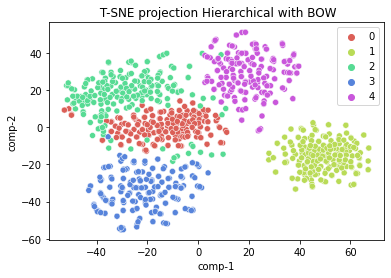

In [248]:
tnesplot(HCpipline,map['X'],map['y'],"Hierarchical True Y with BOW")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.723s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.327523
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.755775
[t-SNE] KL divergence after 1000 iterations: 0.933267


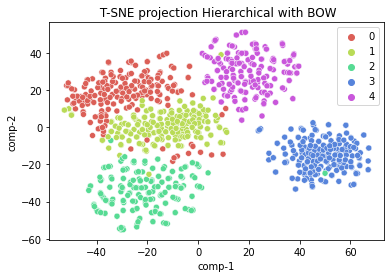

In [249]:
tnesplot(HCpipline,map['X'],map['yhat'],"Hierarchical with BOW")

In [250]:
HCpipline1 = Pipeline(
    [
        ("preprocessor", preprocessor1),
        ("clusterer", HC)
    ]
)

In [251]:
map,yhat=eva(HCpipline1,X,y,'HC')

the silhouette score is : 0.53
the v_measure score is : 0.77
the cohen kappa score is : 0.86


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.002s...
[t-SNE] Computed neighbors for 1000 samples in 0.034s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.830429
[t-SNE] KL divergence after 1000 iterations: 0.311233


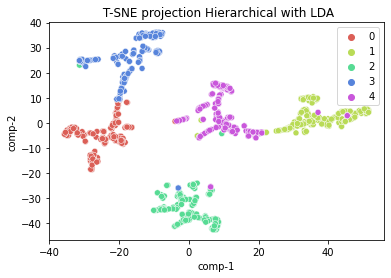

In [252]:
tnesplot(HCpipline1,map['X'],map['y'],"Hierarchical True Y with LDA")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.830429
[t-SNE] KL divergence after 1000 iterations: 0.311233


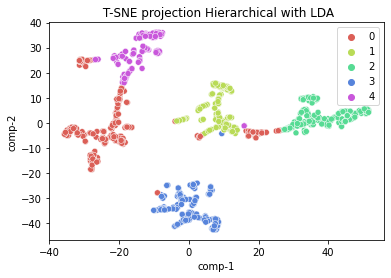

In [253]:
tnesplot(HCpipline1,map['X'],map['yhat'],"Hierarchical with LDA")

In [254]:
HCpipline2 = Pipeline(
    [
        ("preprocessor", preprocessor2),
        ("clusterer", HC)
    ]
)

In [255]:
map,yhat=eva(HCpipline2,X,y,'HC')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


the silhouette score is : 0.03
the v_measure score is : 0.92
the cohen kappa score is : 0.96


[t-SNE] Computing 91 nearest neighbors...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Indexed 1000 samples in 0.011s...
[t-SNE] Computed neighbors for 1000 samples in 0.408s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.347501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.747002
[t-SNE] KL divergence after 1000 iterations: 0.755191


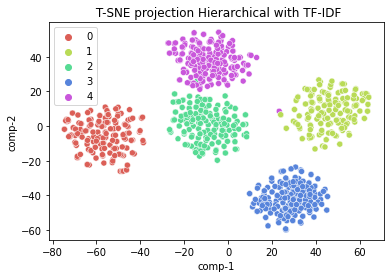

In [256]:
tnesplot(HCpipline2,map['X'],map['newy'],"Hierarchical True Y with TF-IDF")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.420s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.347501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.747002
[t-SNE] KL divergence after 1000 iterations: 0.755191


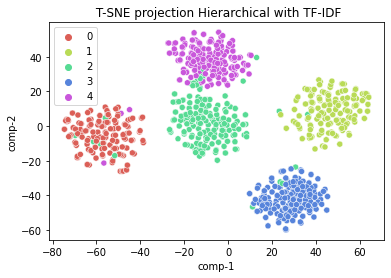

In [257]:
tnesplot(HCpipline2,map['X'],map['yhat'],"Hierarchical with TF-IDF")

EM

In [258]:
EMpipline = Pipeline(
    [
        ("preprocessor", preprocessor3),
        ("clusterer", EM)
    ]
)

In [259]:
map,yhat=eva(EMpipline,X,y,'EM')

the silhouette score is : 0.02
the v_measure score is : 0.64
the cohen kappa score is : 0.64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.468941
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.996826
[t-SNE] KL divergence after 1000 iterations: 0.996288


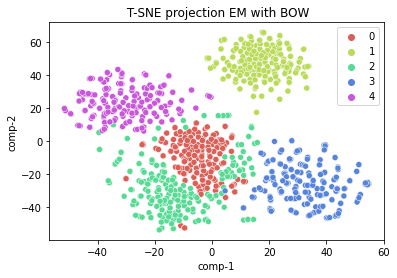

In [260]:
tnesplot(EMpipline,map['X'],map['y'],"EM True Y with BOW")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5.468941
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.996826
[t-SNE] KL divergence after 1000 iterations: 0.996288


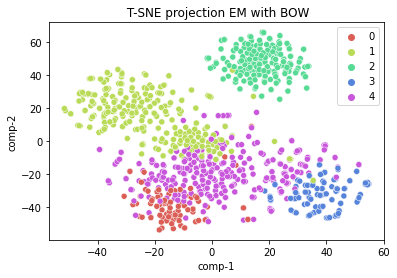

In [261]:
tnesplot(EMpipline,map['X'],map['yhat'],"EM with BOW")

In [262]:
EMpipline1 = Pipeline(
    [
        ("preprocessor", preprocessor4),
        ("clusterer", EM)
    ]
)

In [263]:
map,yhat=eva(EMpipline1,X,y,'EM')

the silhouette score is : 0.04
the v_measure score is : 0.94
the cohen kappa score is : 0.97


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.366741
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.075363
[t-SNE] KL divergence after 1000 iterations: 0.812374


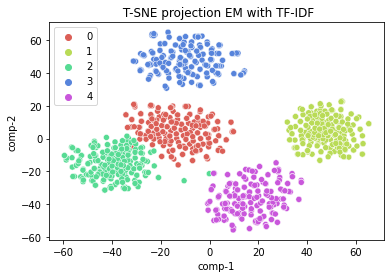

In [264]:
tnesplot(EMpipline1,map['X'],map['y'],"EM with TF-IDF")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.366741
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.075363
[t-SNE] KL divergence after 1000 iterations: 0.812374


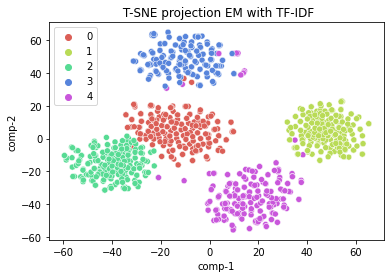

In [265]:
tnesplot(EMpipline1,map['X'],map['yhat'],"EM with TF-IDF")

In [266]:
EMpipline2 = Pipeline(
    [
        ("preprocessor", preprocessor5),
        ("clusterer", EM)
    ]
)

In [267]:
map,yhat=eva(EMpipline2,X,y,'EM')

the silhouette score is : 0.58
the v_measure score is : 0.79
the cohen kappa score is : 0.87


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000019
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.459602
[t-SNE] KL divergence after 1000 iterations: 0.245196


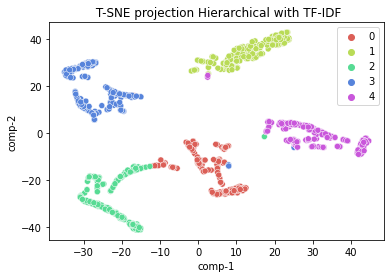

In [268]:
tnesplot(EMpipline2,map['X'],map['y'],"Hierarchical with TF-IDF")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000019
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.459602
[t-SNE] KL divergence after 1000 iterations: 0.245196


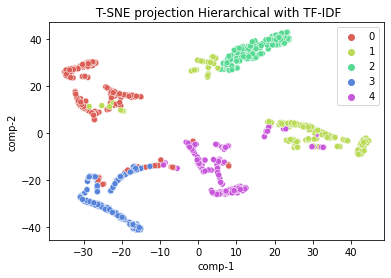

In [269]:
tnesplot(EMpipline2,map['X'],map['yhat'],"Hierarchical with TF-IDF")

# erorr analysis 

champion model is TF-IDF with Kmeans 

In [276]:
map,yhat=eva(KMpipline2,X,y,'kmeans')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


the silhouette score is : 0.03
the v_measure score is : 0.95
the cohen kappa score is : 0.98


In [277]:
newmap=wrongdata(map)
newmap


,yhat,X,y,newy
826,4,moral part perform perform cannot live law app...,0,3
337,0,acquiesc morrow post jane could bear astonish ...,1,1
89,0,height five cubit line thirti cubit compass ro...,2,4
103,0,8 5 angel took censer fill fire altar cast ear...,2,4
134,0,28 overlaid cherubim gold 6 29 carv wall hous ...,2,4
168,3,choic one bare daughter saw bless yea queen co...,2,4
459,3,unanel reckon made sent account imperfect head...,3,2
483,3,youth rebel though none els near ophelia shall...,3,2
491,3,set much modesti cun rememb one said sallet li...,3,2
512,0,voltemand corneliu welcom good friend say volt...,3,2


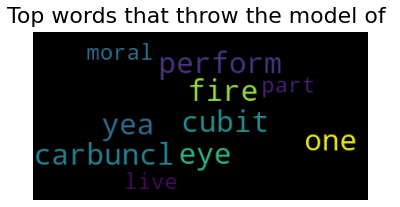

In [278]:
wc = wordcloud.WordCloud(background_color='black', max_words=10, 
                         max_font_size=35)
wc = wc.generate(str(newmap['X']))
fig = plt.figure(num=1)
plt.axis('off')
plt.title('Top words that throw the model of ', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc, cmap=None)
plt.show()

# BigramAssocMeasures 

In [280]:

#make the data redy for the BigramAssocMeasures
bigram_measures = nltk.collocations.BigramAssocMeasures()
L=[]
for i in range(len(newmap)):
  for j in range(i+1,len(newmap)):
    finder = BigramCollocationFinder.from_words(newmap.iloc[i ,1].split(' '))
    record1 = set(finder.nbest(bigram_measures.pmi, 25))
    finder2 = BigramCollocationFinder.from_words(newmap.iloc[j ,1].split(' '))
    record2 = set(finder2.nbest(bigram_measures.pmi, 25))
    intersect = record1.intersection(record2)
    if intersect:
      L.append(intersect)






[{('brother', 'ungraci')}, {('complexion', 'smear'), ('drive', 'rage'), ('bak', 'impast'), ('especi', 'speak'), ('aenea', 'tale'), ('anon', 'find'), ('fire', 'thu'), ('ersiz', 'coagul'), ('command', 'unequ'), ('daughter', 'son'), ('damn', 'light'), ('discret', 'first'), ('dido', 'thereabout'), ('couch', 'omin'), ('coagul', 'gore'), ('carbuncl', 'hellish')}, {('drive', 'rage'), ('ersiz', 'coagul'), ('fire', 'thu'), ('command', 'unequ'), ('discret', 'first'), ('coagul', 'gore'), ('carbuncl', 'hellish')}, {('drive', 'rage'), ('discret', 'first'), ('command', 'unequ'), ('carbuncl', 'hellish')}, {('drive', 'rage'), ('ear', 'lo'), ('declin', 'milki'), ('first', 'player'), ('fire', 'thu'), ('ersiz', 'coagul'), ('command', 'unequ'), ('blow', 'flame'), ('feel', 'blow'), ('discret', 'first'), ('base', 'hideou'), ('coagul', 'gore'), ('carbuncl', 'hellish')}, {('drive', 'rage'), ('ear', 'lo'), ('declin', 'milki'), ('first', 'player'), ('command', 'unequ'), ('blow', 'flame'), ('feel', 'blow'), ('di

Counter({('drive', 'rage'): 6, ('command', 'unequ'): 6, ('discret', 'first'): 6, ('carbuncl', 'hellish'): 6, ('fire', 'thu'): 3, ('ersiz', 'coagul'): 3, ('coagul', 'gore'): 3, ('ear', 'lo'): 3, ('declin', 'milki'): 3, ('first', 'player'): 3, ('blow', 'flame'): 3, ('feel', 'blow'): 3, ('base', 'hideou'): 3, ('brother', 'ungraci'): 1, ('complexion', 'smear'): 1, ('bak', 'impast'): 1, ('especi', 'speak'): 1, ('aenea', 'tale'): 1, ('anon', 'find'): 1, ('daughter', 'son'): 1, ('damn', 'light'): 1, ('dido', 'thereabout'): 1, ('couch', 'omin'): 1, ('flame', 'top'): 1, ('bowl', 'round'): 1, ('felli', 'wheel'): 1, ('etern', 'less'): 1, ('break', 'spoke'): 1, ('cyclop', 'hammer'): 1, ('doth', 'rend'): 1, ('air', 'stick'): 1, ('arous', 'vengeanc'): 1, ('arm', 'lie'): 1, ('away', 'power'): 1, ('armour', 'forg'): 1, ('dread', 'thunder'): 1})


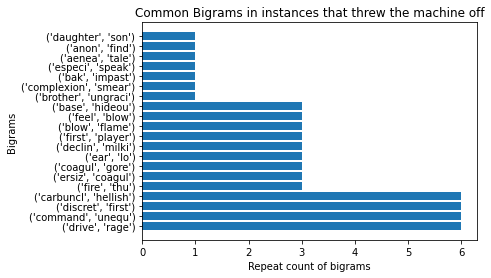

In [281]:
from collections import Counter
C = Counter(x for xs in L for x in xs)
print(C)
import matplotlib.pyplot as plt

y_axis = []
x_axis = []


for i in range(len(C.most_common(20))):
  y_axis.append(str(C.most_common(20)[i][0]))
  x_axis.append(C.most_common(20)[i][1])

plt.barh(y_axis,x_axis)
plt.title('Common Bigrams in instances that threw the machine off')
plt.xlabel('Repeat count of bigrams')
plt.ylabel('Bigrams')
plt.show()